In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#Load the modules
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to save all the RAM we can
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
#

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


Load the labels and filenames

In [2]:
#set paths to training and test data
path = "../input/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(3) # print the first three entrys

,path,id,label
0,../input/train/53cd84dd8190c3b61869e5c6e364ef7...,53cd84dd8190c3b61869e5c6e364ef71618d0803,0
1,../input/train/1fd38079166dec3f0b2d10111c1326b...,1fd38079166dec3f0b2d10111c1326beaa71ab7b,0
2,../input/train/698888e4039fcc82bec0414a5a1c452...,698888e4039fcc82bec0414a5a1c452673a075de,0


Load the images

In [3]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [4]:
# Load 10k images
N=10000
X,y = load_data(N=N,df=df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Exploratory Data Analysis (EDA)  
1. 看一下图片
2. 了解两种类别的分布情况
3. 看一下特征

some example images

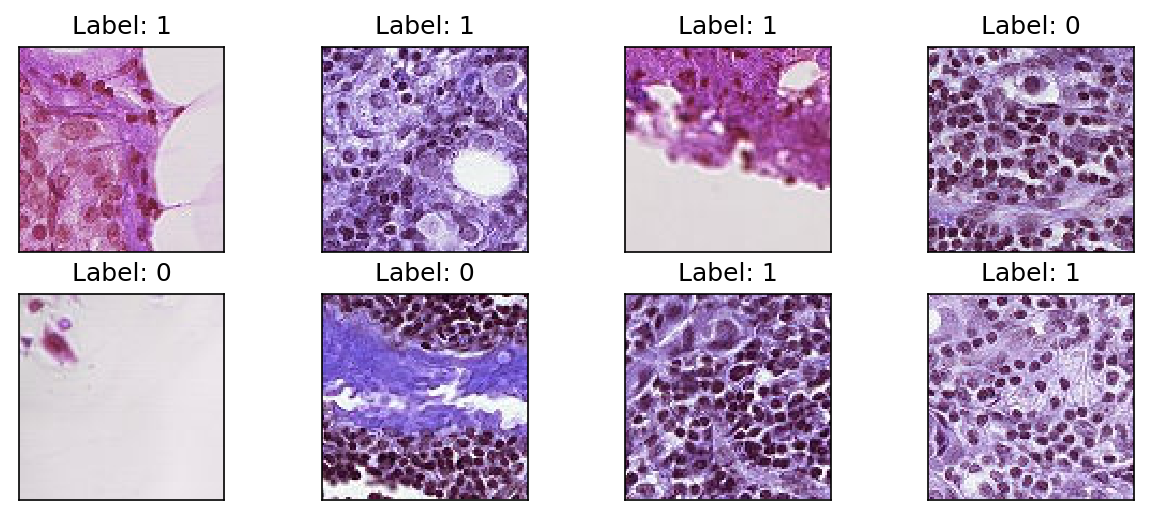

In [5]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

the data distribution

Text(0, 0.5, '# of samples')

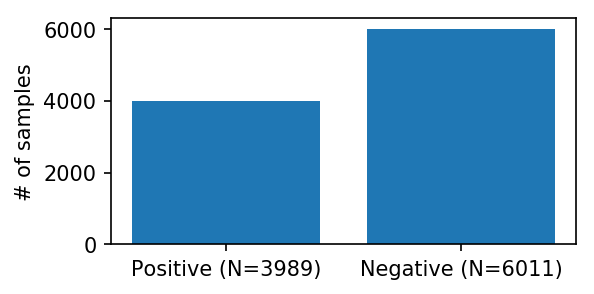

In [6]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

过采样和欠采样可以避免分类器中的偏差并改善训练期间的稳定性

In [7]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

compare the distribution of pixel values for each color channel (RGB) individually and all channels together

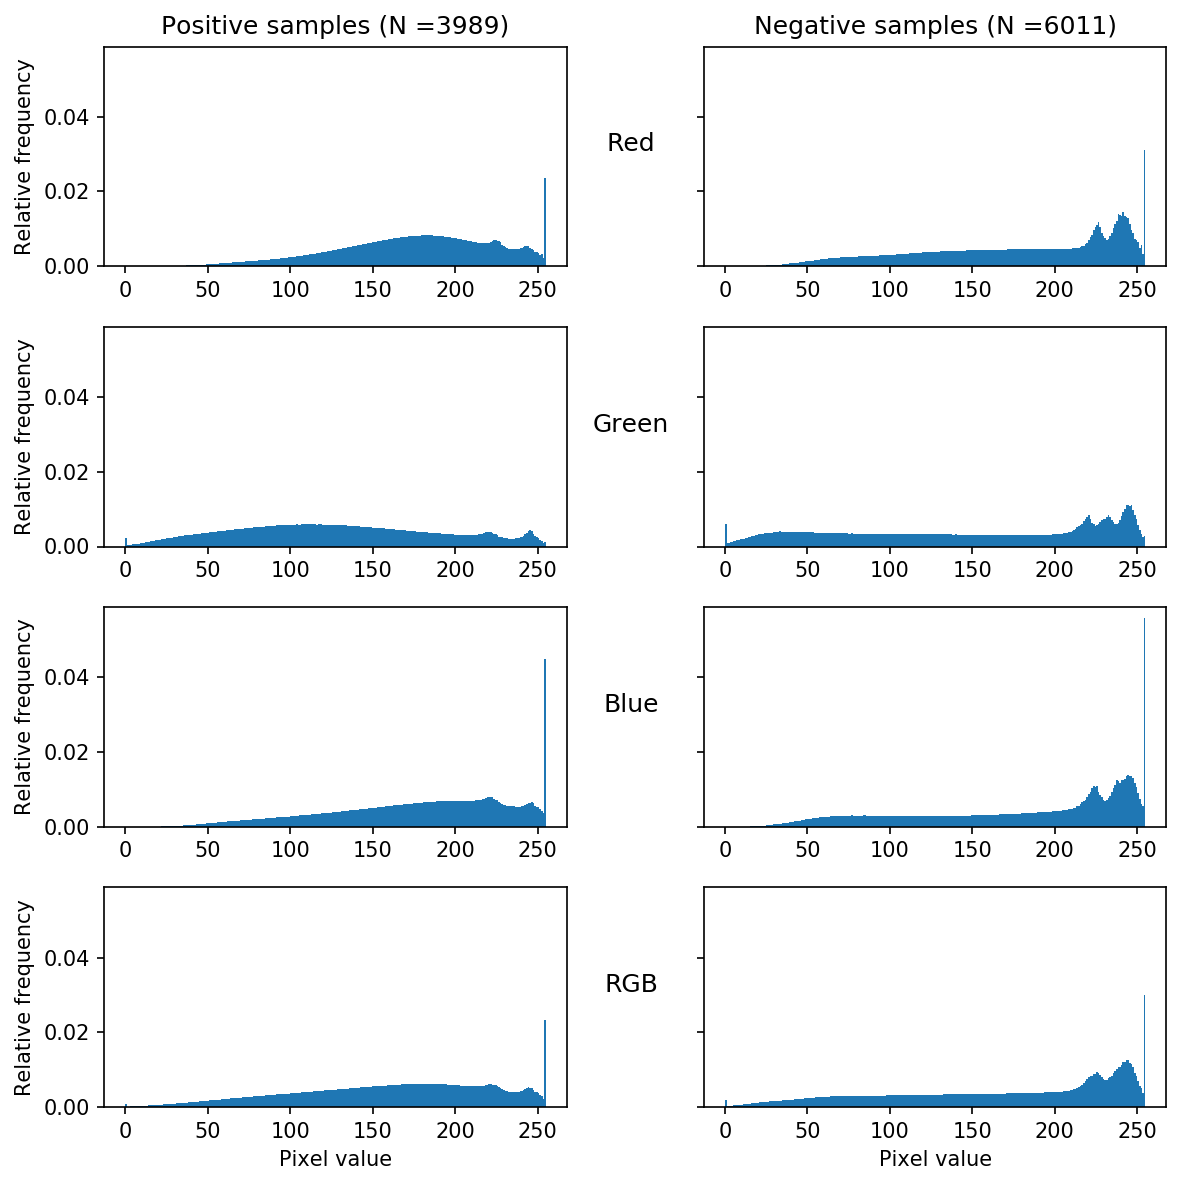

In [8]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

1. 与正样本相比，负样本像素更多在高亮度部分，特别是在绿通道中  
2. 正样本中，相比于其他两通道，绿通道中的像素更暗。而负样本不是这样
3. 正负样本中都存在大部分亮白色区域

take the mean of each individual image and look at that distribution.

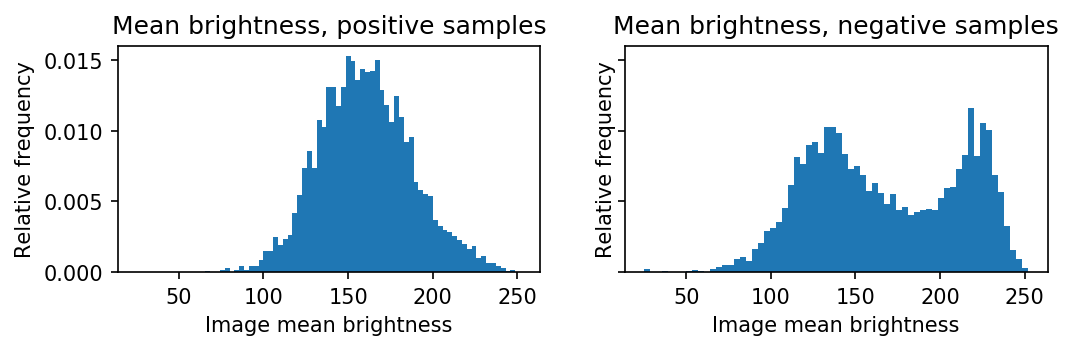

In [9]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

1. 正样本的平均亮度分布接近于均值为150正态分布
2. 负样本近似双峰分布，峰值为140和225

通过EDA，我们可以得到以下结论
1. 正负样本在像素的分布和平均亮度的分布上有明显的区别，我们的模型可以利用这一点
2. 一些图片包含了很亮的区域，可能是记录过程中的人为因素导致，我们需要找到一种方法解决他们。他们在正负样本中都有，所以不能当作一个特征
3. 负样本多于正样本很多，可能需要调整

loading all the data

In [10]:
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


free up space in our RAM

In [11]:
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

split the data into a training and validation set

In [12]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

neural network architecture

In [13]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

Train and validate the model

In [15]:
#normally you would want to reshuffle the data between epochs, we don't as we split in-place into training/validation
epochs = 3 #how many epochs we want to perform
for epoch in range(epochs):
    #compute how many batches we'll need
    iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
    loss,acc = 0,0 #we will compute running loss and accuracy
    with trange(iterations) as t: #display a progress bar
        for i in t:
            start_idx = i * batch_size #starting index of the current batch
            x_batch = X[start_idx:start_idx+batch_size] #the current batch
            y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

            metrics = model.train_on_batch(x_batch, y_batch) #train the model on a batch

            loss = loss + metrics[0] #compute running loss
            acc = acc + metrics[1] #compute running accuracy
            t.set_description('Running training epoch ' + str(epoch)) #set progressbar title
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) #display metrics

  0%|          | 0/3520 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


Running training epoch 1:  70%|██████▉   | 2448/3520 [01:19<00:34, 30.64it/s, acc=0.89, loss=0.27]

Create a submission

In [16]:
X = None
y = None
gc.collect();

In [17]:
base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

Indexes: 0 - 5000
5000/5000 [==============================] - 1s 273us/step
Indexes: 5000 - 10000
5000/5000 [==============================] - 1s 211us/step
Indexes: 10000 - 15000
5000/5000 [==============================] - 1s 219us/step
Indexes: 15000 - 20000
5000/5000 [==============================] - 1s 216us/step
Indexes: 20000 - 25000
5000/5000 [==============================] - 1s 229us/step
Indexes: 25000 - 30000
5000/5000 [==============================] - 1s 211us/step
Indexes: 30000 - 35000
5000/5000 [==============================] - 1s 216us/step
Indexes: 35000 - 40000
5000/5000 [==============================] - 1s 212us/step
Indexes: 40000 - 45000
5000/5000 [==============================] - 1s 210us/step
Indexes: 45000 - 50000
5000/5000 [==============================] - 1s 210us/step
Indexes: 50000 - 55000
5000/5000 [==============================] - 1s 211us/step
Indexes: 55000 - 60000
2458/2458 [==============================] - 1s 217us/step


,id,label
0,32f1b12658ee029b299d40914f9130ffaf884ca8,0.344094
1,f20a6bdd5b40179a84b3b313132144e614e4ea3f,0.015014
2,c2419ee7bafb7ed8c9196f3c0c969669ef20d103,0.244969
3,d8c61ba09ab2b27f79d146611415d597cb73f524,0.007712
4,12b32fec2e5714c6e708e65bc36886e0d56f15d4,0.016618


In [18]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file